# Lane Detection Project

In this project you need to construct computer vision solution for a lane detection. We are going to implement [LaneNet](https://arxiv.org/pdf/1802.05591.pdf) paper. Our solution is going to have the following parts:

1. Lane semantic segmentation and metric learning
2. Instance segmentation over embedings
3. Homography prediction
4. Lane fitting

We are going to use [TuSimple](https://github.com/TuSimple/tusimple-benchmark/issues/3) dataset for a lane detection.

Let's discuss every step in details.

## Semantic and Instance Segmentation

In this part you should implement and train neural network with the 2 heads. The model should take as an input image and returns to masks. One head should predict *semantic segmentation* and another head should predict *embedding for each pixel*. Pixels that are part of one lane should have similar embeddings, on the other hand pixels from different lanes should have high distance between embeddings. In order to do that, we should implement *discriminative loss*.

After training the discribed network, we can threshold pixels of the interest and cluster them according to the embedding with the *DBSCAN*.

After solving the problem you should obtain the following result.

## Homograpy Prediction

In order to solve the problem, we would like to understand an exact lane geometry. We are going to describe the lane with the 2-nd order polynom $ax^2 + bx + c$.

In the image plane lines are not parallel and we may need higher order polynoms to discribe the lane geometry. In order to avoid that we could project image in the bird's eye view with the homography. But drivable surface has different properties over frames, so we would like to condition the homography on the image.

In order to do that, we going to train separate network to predict the best homography for each image.

## Lane Fitting

After predicting homography and lane's clustering we will fit 2-nd order polynom for each lane to obtain the final result. Lane fitting can be formulated as a least-squares problem, where we have points $\{x_i, y_i\}_{i=1}^n$ and we would like to estimation coefficients $a, b, c$ s.t.

$$
\sum_{i = 1}^n ||y_i - a x_i^2 - bx_i - c||^2 \rightarrow \min_{a, b,c}
$$



## Important Notes
0. During the project we provide the relevant papers. Reading the papers can be very helpful (and sometimes necessary) to implement the code.
1. During the project we provide you with the code templates that you should fill.
2. Homography Prediction and Instance Segmentation can be done in parallel.
3. You are free to use any other environment instead of Google Colab.
4. You can deviate from the original papers if it helps you to solve the problem, but you should explain your solution and motivation in the text block.

In [1]:
import pandas as pd 
import os
import sys
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
import orjson as json
from torch.nn.modules.loss import _Loss
import matplotlib.pyplot as plt
import cv2
import tqdm
import argparse
from sklearn.cluster import DBSCAN
import json

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Semantic and Segmentation Code

You can use the following commands to download the dataset and unpack it. But we suggest to upload the data to the Google Drive, with Google Drive you will be able to access the data much faster.For this task we are going to use ENet architecture. You can read the description in the [original paper](https://arxiv.org/pdf/1606.02147.pdf).

To generate two different outputs we need to have two different branches. In the LaneNet paper authers proposed to share only two first sections of the encoder between to tasks. Third section and decoder should be separate for the instance segmentation and binary segmentation problem.

The output dimension of the instance segmentation embedding should be equal to 5.

In the following cell you should implement pytorch Dataset to generate training examples for instance and semantic segmentation. You are able to modify the signatures if you want.

To implement the LaneDataset you should become familiar with the labeling format.

The dataset is relatively small, so it is important to implement different augmentation strategies. We suggest to use random flips and color augmentations (brightness, saturation). You can also use augmentations of your choice. Augmentations are not required to obtain a full grade but without them your model could overfit dramatically.

NOTE: It can be useful to generate binary segmentation and instance segmentation ground truth once and then use it as-is in every experiment.

`Let's create a class for the lane splitting task. This class use for reading images, process labels, create instance and segmentation masks, and format the data needed to train deep learning models. Labels contain the lane coordinates and information needed to create a segmentation mask that represents the lanes in the image`:

In [2]:
DEFAULT_SIZE = (256, 512)
DATA_PATH = "/kaggle/input/tusimple/TUSimple/train_set"

class LaneDataset(Dataset):
    def __init__(self, dataset_path=DATA_PATH, train=True, size=DEFAULT_SIZE):
        self._dataset_path = dataset_path
        self._mode = "train" if train else "eval"
        self._image_size = size
        self._data = []
        self._process_labels()

    def __getitem__(self, idx):
        image_path = os.path.join(self._dataset_path, self._data[idx][0])
        image = cv2.imread(image_path)
        h, w, c = image.shape
        image = cv2.resize(image, self._image_size, interpolation=cv2.INTER_LINEAR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image[..., None]
        lanes = self._data[idx][1]

        segmentation_image = self._draw_lanes(h, w, lanes, "segmentation")
        instance_image = self._draw_lanes(h, w, lanes, "instance")
        instance_image = instance_image[..., None]

        image = torch.from_numpy(image).float().permute((2, 0, 1))
        segmentation_image = torch.from_numpy(segmentation_image.copy())
        instance_image = torch.from_numpy(instance_image.copy()).permute((2, 0, 1))
        segmentation_image = segmentation_image.to(torch.int64)

        return image, segmentation_image, instance_image

    def __len__(self):
        return len(self._data)

    def _draw_lanes(self, h, w, lanes, image_type):
        image = np.zeros((h, w), dtype=np.uint8)
        for i, lane in enumerate(lanes):
            color = 1 if image_type == "segmentation" else i + 1
            cv2.polylines(image, [lane], False, color, 10)

        image = cv2.resize(image, self._image_size, interpolation=cv2.INTER_NEAREST)
        return image

    def _process_labels(self):
        label_files = []
        if self._mode == "train":
            label_files = [os.path.join(self._dataset_path, f"label_data_{suffix}.json") for suffix in ("0313", "0531")]
        elif self._mode == "eval":
            label_files = [os.path.join(self._dataset_path, f"label_data_{suffix}.json") for suffix in ("0601",)]

        for label_file in label_files:
            with open(label_file) as f:
                for line in f:
                    info = json.loads(line)
                    image = info["raw_file"]
                    lanes = info["lanes"]
                    h_samples = info["h_samples"]
                    lanes_coords = []
                    for lane in lanes:
                        x = np.array([lane]).T
                        y = np.array([h_samples]).T
                        xy = np.hstack((x, y))
                        idx = np.where(xy[:, 0] > 0)
                        lane_coords = xy[idx]
                        lanes_coords.append(lane_coords)
                    self._data.append((image, lanes_coords))


Initialize the class:

In [5]:
lane = LaneDataset()
image, segment, ins = lane[5]
ins = ins.to(device=torch.device('cuda'))

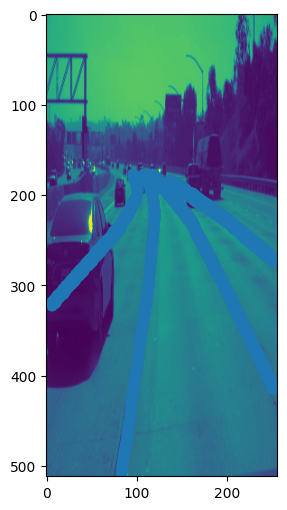

In [6]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.imshow(image.squeeze())
ax.scatter(x=ins.nonzero(as_tuple=True)[2].cpu(), y=ins.nonzero(as_tuple=True)[1].cpu())
plt.show()

In [6]:
ins = ins.cpu()
image = image.cpu()

For this task we are going to use ENet architecture. You can read the description in the [original paper](https://arxiv.org/pdf/1606.02147.pdf).

To generate two different outputs we need to have two different branches. In the LaneNet paper authers proposed to share only two first sections of the encoder between to tasks. Third section and decoder should be separate for the instance segmentation and binary segmentation problem.

The output dimension of the instance segmentation embedding should be equal to 5.

`The architecture of network is presented on picture. It is divided into several stages, as highlighted by horizontal lines in the table and the first digit after each block name.`

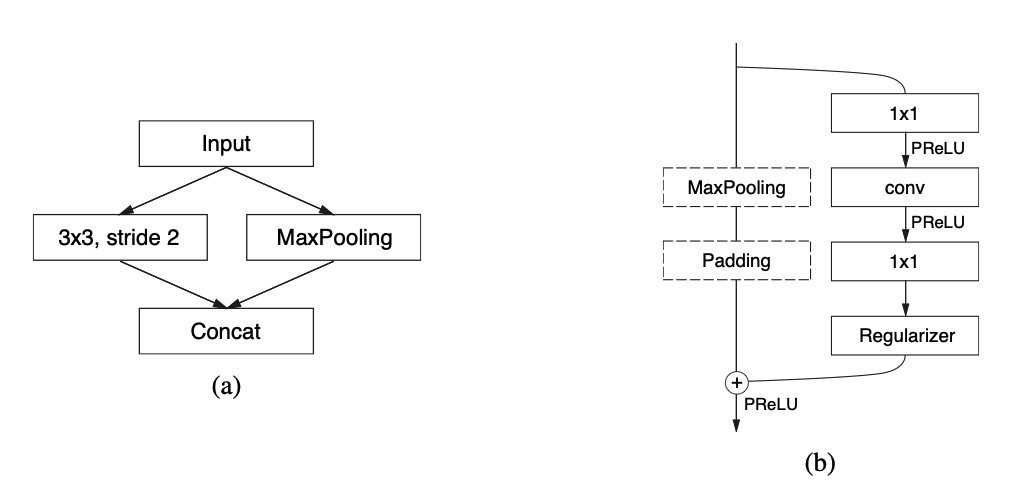

`(a) ENet initial block. MaxPooling is performed with non-overlapping 2 × 2 windows, and the convolution has 13 filters, which sums up to 16 feature maps after concatenation. (b) ENet bottleneck module. conv is either a regular, dilated, or full convolution (also known as deconvolution) with 3 × 3 filters, or a 5 × 5 convolution decomposed into two asymmetric ones.`

`Also we use special bottleneck architecture: "If the bottleneck is downsampling, a max pooling layer is added to the main branch. Also, the first 1 × 1 projection is replaced with a 2 × 2 convolution with stride 2 in both dimen- sions. We zero pad the activations, to match the number of feature maps. conv is either a regular, dilated or full convolution (also known as deconvolution or fractionally strided convolu- tion) with 3 × 3 filters. Sometimes we replace it with asymmetric convolution i.e. a sequence of 5 × 1 and 1 × 5 convolutions. For the regularizer, we use Spatial Dropout, with p = 0.01 before bottleneck2.0, and p = 0.1 afterwards"` 

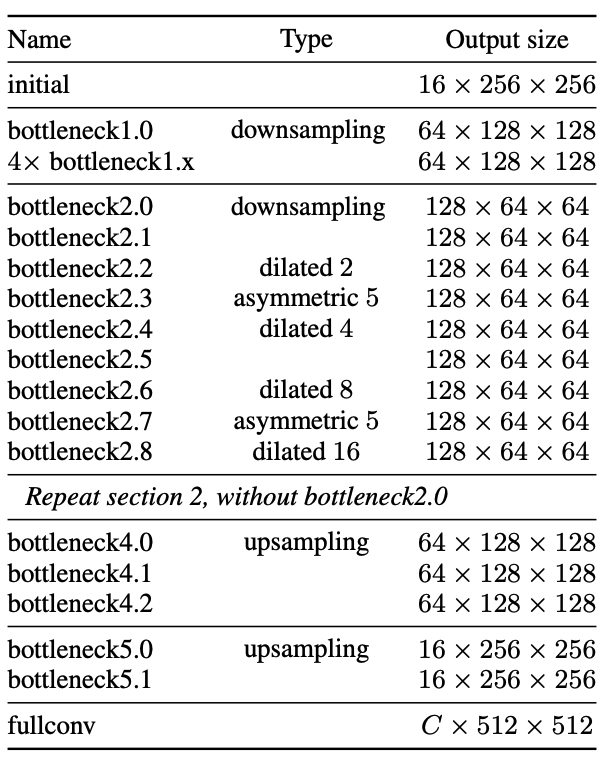

In [189]:
class InitialBlock(nn.Module):

    def __init__(self, in_channels, out_channels, bias=False, act_relu=True, use_gpu = True, **kwargs):
        super().__init__()
        
        device = 'cuda' if use_gpu else 'cpu'
        self.device =  torch.device(device)
        activation = nn.ReLU if act_relu else nn.PReLU
        self.convolution = nn.Conv2d(in_channels, out_channels-1, kernel_size=3, 
                                     stride=2, padding=1, bias=bias, device=self.device)
        self.max_pool = nn.MaxPool2d(3, stride=2, padding=1)
        self.normalization = nn.BatchNorm2d(out_channels, device=self.device)
        self.activation =  activation()


    def forward(self, input_data):
        conv_out = self.convolution(input_data).to(self.device)
        pooled_out = self.max_pool(input_data).to(self.device)
        concat = torch.cat([conv_out, pooled_out], dim=1)
        norm = self.normalization(concat)
        activated = self.activation(norm)
        return activated

In [190]:
class ENetEncoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        device = 'cuda'
        self.device =  torch.device(device)
        
        self.initial_block = InitialBlock(1, 16, **kwargs)

        self.bottleneck1_0 = Bottleneck(16, 16, 64, downsampling=True, dropout=0.01, **kwargs)
        self.bottleneck1_1 = Bottleneck(64, 16, 64, **kwargs)
        self.bottleneck1_2 = Bottleneck(64, 16, 64, **kwargs)
        self.bottleneck1_3 = Bottleneck(64, 16, 64, **kwargs)
        self.bottleneck1_4 = Bottleneck(64, 16, 64, **kwargs)

        self.bottleneck2_0 = Bottleneck(64, 32, 128, downsampling=True, **kwargs)
        self.bottleneck2_1 = Bottleneck(128, 32, 128, **kwargs)
        self.bottleneck2_2 = Bottleneck(128, 32, 128, dilation=2, **kwargs)
        self.bottleneck2_3 = Bottleneck(128, 32, 128, asymmetric=True, **kwargs)
        self.bottleneck2_4 = Bottleneck(128, 32, 128, dilation=4, **kwargs)
        self.bottleneck2_5 = Bottleneck(128, 32, 128, **kwargs)
        self.bottleneck2_6 = Bottleneck(128, 32, 128, dilation=8, **kwargs)
        self.bottleneck2_7 = Bottleneck(128, 32, 128, asymmetric=True, **kwargs)
        self.bottleneck2_8 = Bottleneck(128, 32, 128, dilation=16, **kwargs)

        self.bottleneck3_1 = Bottleneck(128, 32, 128, **kwargs)
        self.bottleneck3_2 = Bottleneck(128, 32, 128, dilation=2, **kwargs)
        self.bottleneck3_3 = Bottleneck(128, 32, 128, asymmetric=True, **kwargs)
        self.bottleneck3_4 = Bottleneck(128, 32, 128, dilation=4, **kwargs)
        self.bottleneck3_5 = Bottleneck(128, 32, 128, **kwargs)
        self.bottleneck3_6 = Bottleneck(128, 32, 128, dilation=8, **kwargs)
        self.bottleneck3_7 = Bottleneck(128, 32, 128, asymmetric=True, **kwargs)
        self.bottleneck3_8 = Bottleneck(128, 32, 128, dilation=16, **kwargs)

    def forward(self, input_data):
  
        x = self.initial_block(input_data).to(self.device)

        x, max_indices1 = self.bottleneck1_0(x)
        x = self.bottleneck1_1(x)
        x = self.bottleneck1_2(x)
        x = self.bottleneck1_3(x)
        x = self.bottleneck1_4(x)

        x, max_indices2 = self.bottleneck2_0(x)
        x = self.bottleneck2_1(x)
        x = self.bottleneck2_2(x)
        x = self.bottleneck2_3(x)
        x = self.bottleneck2_4(x)
        x = self.bottleneck2_5(x)
        x = self.bottleneck2_6(x)
        x = self.bottleneck2_7(x)
        x = self.bottleneck2_8(x)

        x = self.bottleneck3_1(x)
        x = self.bottleneck3_2(x)
        x = self.bottleneck3_3(x)
        x = self.bottleneck3_4(x)
        x = self.bottleneck3_6(x)
        x = self.bottleneck3_7(x)
        x = self.bottleneck3_8(x)

        return x, max_indices1, max_indices2


In [191]:
class ENetDecoder(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super().__init__()

        self.upsampling_bottleneck4_0 = UpsamplingBottleneck(128, 16, 64, **kwargs)
        self.bottleneck4_1 = Bottleneck(64, 16, 64, **kwargs)
        self.bottleneck4_2 = Bottleneck(64, 16, 64, **kwargs)

        self.upsampling_bottleneck5_0 = UpsamplingBottleneck(64, 4, 16, **kwargs)
        self.bottleneck5_1 = Bottleneck(16, 4, 16, **kwargs)

        self.transposed_conv = nn.ConvTranspose2d(16, num_classes, 2, 2, bias=False, device=torch.device('cuda'))

    def forward(self, input_data, max_indices1, max_indices2):
        x = self.upsampling_bottleneck4_0(input_data, max_indices2)
        x = self.bottleneck4_1(x)
        x = self.bottleneck4_2(x)

        x = self.upsampling_bottleneck5_0(x, max_indices1)
        x = self.bottleneck5_1(x)

        # Output
        x = self.transposed_conv(x)
        return x


In [192]:
class Bottleneck(nn.Module):
    def __init__(self, in_dim, inter_dim, out_dim, dilation=1, asymmetric=False,
                 downsampling=False, norm_layer=nn.BatchNorm2d, dropout_rate=0.1, **kwargs):
        super().__init__()
        self.downsampling = downsampling
        
        if downsampling:
            self.maxpool = nn.MaxPool2d(2, 2, return_indices=True)
            self.conv_down = nn.Sequential(
                nn.Conv2d(in_dim, out_dim, 1, bias=False, device=torch.device('cuda')),
                norm_layer(out_dim, device=torch.device('cuda'))
            )

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_dim, inter_dim, 1, bias=False, device=torch.device('cuda')),
            norm_layer(inter_dim, device=torch.device('cuda')),
            nn.PReLU(device=torch.device('cuda'))
        )

        if downsampling:
            self.conv2 = nn.Sequential(
                nn.Conv2d(inter_dim, inter_dim, 2, stride=2, bias=False, device=torch.device('cuda')),
                norm_layer(inter_dim, device=torch.device('cuda')),
                nn.PReLU(device=torch.device('cuda'))
            )
        else:
            if asymmetric:
                self.conv2 = nn.Sequential(
                    nn.Conv2d(inter_dim, inter_dim, (5, 1), padding=(2, 0), bias=False, device=torch.device('cuda')),
                    nn.Conv2d(inter_dim, inter_dim, (1, 5), padding=(0, 2), bias=False, device=torch.device('cuda')),
                    norm_layer(inter_dim, device=torch.device('cuda')),
                    nn.PReLU(device=torch.device('cuda'))
                )
            else:
                self.conv2 = nn.Sequential(
                    nn.Conv2d(inter_dim, inter_dim, 3, dilation=dilation, padding=dilation, bias=False, device=torch.device('cuda')),
                    norm_layer(inter_dim, device=torch.device('cuda')),
                    nn.PReLU(device=torch.device('cuda'))
                )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(inter_dim, out_dim, 1, bias=False, device=torch.device('cuda')),
            norm_layer(out_dim, device=torch.device('cuda')),
            nn.Dropout2d(dropout_rate)
        )
        
        self.activation = nn.PReLU(device=torch.device('cuda'))

    def forward(self, x):
        identity = x
        
        if self.downsampling:
            identity, max_indices = self.maxpool(identity)
            identity = self.conv_down(identity)

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.activation(out + identity)

        if self.downsampling:
            return out, max_indices
        else:
            return out


In [193]:
class UpsamplingBottleneck(nn.Module):

    def __init__(self, in_ch, inter_ch, out_ch, norm_layer=nn.BatchNorm2d, drop_prob=0.1, **kwargs):
        super().__init__()
        self.convolution = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 1, bias=False, device=torch.device('cuda')),
            norm_layer(out_ch, device=torch.device('cuda'))
        )
        self.upsampling_op = nn.MaxUnpool2d(2)

        self.block_operations = nn.Sequential(
            nn.Conv2d(in_ch, inter_ch, 1, bias=False, device=torch.device('cuda')),
            norm_layer(inter_ch, device=torch.device('cuda')),
            nn.PReLU(device=torch.device('cuda')),
            nn.ConvTranspose2d(inter_ch, inter_ch, 2, 2, bias=False,device=torch.device('cuda')),
            norm_layer(inter_ch, device=torch.device('cuda')),
            nn.PReLU(device=torch.device('cuda')),
            nn.Conv2d(inter_ch, out_ch, 1, bias=False, device=torch.device('cuda')),
            norm_layer(out_ch, device=torch.device('cuda')),
            nn.Dropout2d(drop_prob)
        )
        self.activation = nn.PReLU(device=torch.device('cuda'))

    def forward(self, input_x, max_indices):
        output_upsampled = self.convolution(input_x)
        output_upsampled = self.upsampling_op(output_upsampled, max_indices)

        output_extended = self.block_operations(input_x)
        output = self.activation(output_upsampled + output_extended)
        return output


In [194]:
class ENet(nn.Module):
    def __init__(self, a, b):
        super(ENet, self).__init__()

        self.encoder_net = ENetEncoder()
        self.decoder_logits = ENetDecoder(a)
        self.decoder_embeddings = ENetDecoder(b)

    def forward(self, input_data):
        x, max_indices1, max_indices2 = self.encoder_net(input_data)

        logits = self.decoder_logits(x, max_indices1, max_indices2)
        embeddings = self.decoder_embeddings(x, max_indices1, max_indices2)

        return embeddings, logits


In [195]:
test_input = torch.ones((1, 1, 256, 512), device=torch.device('cuda'))
enet = ENet(2, 4)
binary, instance = enet(test_input)
print(binary.shape)
print(instance.shape)

torch.Size([1, 4, 256, 512])
torch.Size([1, 2, 256, 512])


In [196]:
s_pred, ins_pred = enet(image[None, ...].to(device=torch.device('cuda')))

print(s_pred.shape)
print(ins_pred.shape)

torch.Size([1, 4, 512, 256])
torch.Size([1, 2, 512, 256])


In [200]:
ins_pred = ins_pred.cpu()

To obtain the instance segmentation we should train the embeddings as we described in the project description. In order to do that we need to implement [Discriminative Loss](https://arxiv.org/pdf/1708.02551.pdf). Discriminative loss consists of three parts:

1. Inter-cluster push-force: cluster means should be far away from each other
2. Intra-cluster pull-force: embeddings should be close to the center of the corresponding cluster.
3. Regularization: cluster centers should be close to zero.

Corresponding weights for the losses and other hyper-parameters could be found in the paper.

`This class calculates and accumulates the variance loss (var_loss), distance loss (dis_loss), and regularization loss (reg_loss) for all samples in the batch. Scale each loss by its respective factor (alpha, beta, gamma) and average it across batches (num_samples). Returns the composite loss computed as the weighted sum of the variance loss, distance loss, and regularization loss for all samples in the batch:`

In [201]:
class DiscriminativeLoss(_Loss):
    def __init__(self, delta_var=0.5, delta_dist=3, norm=2, alpha=1.0, beta=1.0, gamma=0.001,use_gpu=True, reduction="mean", n_clusters=4):
        
        super().__init__(reduction=reduction)
        
        device = 'cuda' if use_gpu else 'cpu'
        
        self.delta_var = delta_var
        self.delta_dist = delta_dist
        self.norm = norm
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.device = torch.device(device)
        self.n_clusters = n_clusters

    def forward(self, input, target):
        
        num_samples = target.size(0)
        dis_loss = torch.tensor(0.).to(self.device)
        var_loss = torch.tensor(0.).to(self.device)
        reg_loss = torch.tensor(0.).to(self.device)
        
        for i in range(num_samples):
            clusters = list()
            sample_emb = input[i,:,:,:]
            sample_lbl = target[i,:,:].squeeze()
            num_cl = len(sample_lbl.unique()) - 1
            vals = sample_lbl.unique()[1:]
            sample_lbl = sample_lbl.view(sample_lbl.size(0) * sample_lbl.size(1))
            sample_emb = sample_emb.view(-1, sample_emb.size(1) * sample_emb.size(2))
            v_loss = torch.tensor(0.).to(self.device)
            d_loss = torch.tensor(0.).to(self.device)
            r_loss = torch.tensor(0.).to(self.device)
            
            for j in range(num_cl):
                indices = (sample_lbl == vals[j]).nonzero()
                indices = indices.squeeze()
                cl_elements = torch.index_select(sample_emb, 1, indices)
                num_elements = cl_elements.size(1)
                mean_cl = cl_elements.mean(dim=1, keepdim=True)
                clusters.append(mean_cl)
                v_loss += torch.pow((torch.clamp(torch.norm(cl_elements - mean_cl) - self.delta_var, min=0.)), 2).sum() / num_elements
                r_loss += torch.sum(torch.abs(mean_cl))
                
            for index in range(num_cl):
                for idx, cl in enumerate(clusters):
                    if index == idx:
                        continue 
                    else:
                        distance = torch.norm(clusters[index] - cl)
                        d_loss += torch.pow(torch.clamp(self.delta_dist - distance, min=0.), 2)
                        
            var_loss += v_loss / num_cl
            dis_loss += d_loss / (num_cl * (num_cl - 1))
            reg_loss += r_loss / num_cl
            loss = self.alpha * (var_loss / num_samples) + self.beta * (dis_loss / num_samples) + self.gamma * (reg_loss / num_samples)
            
        return loss

In [202]:
DiscriminativeLoss(delta_var=0.5, delta_dist=3, alpha=1.0, beta=1.0, gamma=0.001, use_gpu=True)(ins_pred, ins)

tensor(10.0977, device='cuda:0', grad_fn=<AddBackward0>)

In [203]:
def compute_loss(bin_out, inst_out, bin_lbl, inst_lbl):
    
    ce_loss = nn.CrossEntropyLoss()
    binary_loss = ce_loss(bin_out, bin_lbl)

    ds_loss = DiscriminativeLoss(delta_var=0.5, delta_dist=3, alpha=1.0, beta=1.0, gamma=0.001, use_gpu=True)
    instance_loss = ds_loss(inst_out, inst_lbl)
    
    return binary_loss, instance_loss

In [205]:
batch_size = 16
learning_rate = 5e-4
num_epochs = 13

train_loader = torch.utils.data.DataLoader(LaneDataset(), batch_size=batch_size, shuffle=False)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("gpu")

model = ENet(2, 4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0002)

for epoch in range(num_epochs):
    model.train()
    losses = []
    for img, bin_target, inst_target in tqdm.tqdm(train_loader):
        img, bin_target, inst_target = img.to(device), bin_target.to(device), inst_target.to(device)
        optimizer.zero_grad()

        bin_logits, inst_emb = model(img)
        bin_loss, inst_loss = compute_loss(bin_logits, inst_emb, bin_target, inst_target)
        
        loss = bin_loss + inst_loss
        loss.backward()
        optimizer.step()
        
        losses.append((bin_loss.detach().cpu(), inst_loss.detach().cpu()))

    mean_losses = torch.tensor(losses).mean(dim=0)
    print(f"Epoch {epoch}: Loss = {mean_losses}")

100%|██████████| 201/201 [01:54<00:00,  1.76it/s]


Epoch 0: Loss = tensor([0.7005, 2.8167])


100%|██████████| 201/201 [01:51<00:00,  1.80it/s]


Epoch 1: Loss = tensor([0.1620, 0.5229])


100%|██████████| 201/201 [01:50<00:00,  1.82it/s]


Epoch 2: Loss = tensor([0.1053, 0.3134])


100%|██████████| 201/201 [01:50<00:00,  1.83it/s]


Epoch 3: Loss = tensor([0.0835, 0.2171])


100%|██████████| 201/201 [01:50<00:00,  1.81it/s]


Epoch 4: Loss = tensor([0.0725, 0.1710])


100%|██████████| 201/201 [01:50<00:00,  1.81it/s]


Epoch 5: Loss = tensor([0.0668, 0.1509])


100%|██████████| 201/201 [01:51<00:00,  1.80it/s]


Epoch 6: Loss = tensor([0.0622, 0.1140])


100%|██████████| 201/201 [01:51<00:00,  1.80it/s]


Epoch 7: Loss = tensor([0.0589, 0.1021])


100%|██████████| 201/201 [01:50<00:00,  1.82it/s]


Epoch 8: Loss = tensor([0.0576, 0.0929])


100%|██████████| 201/201 [01:50<00:00,  1.82it/s]


Epoch 9: Loss = tensor([0.0557, 0.0811])


100%|██████████| 201/201 [01:51<00:00,  1.81it/s]


Epoch 10: Loss = tensor([0.0534, 0.0651])


100%|██████████| 201/201 [01:50<00:00,  1.82it/s]


Epoch 11: Loss = tensor([0.0523, 0.0575])


100%|██████████| 201/201 [01:59<00:00,  1.68it/s]

Epoch 12: Loss = tensor([0.0515, 0.0568])


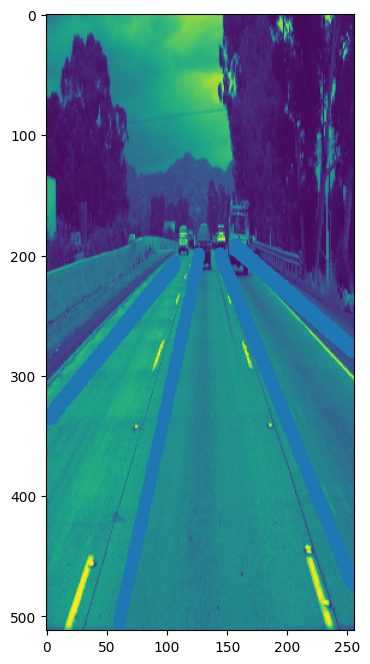

In [128]:
eval_dataset = LaneDataset(train=False)
eval_img, *_ = eval_dataset[0]
eval_img = eval_img.to(device)

bin_logits, inst_emb = model(eval_img[None, ...])
eval_img.shape, bin_logits.shape, inst_emb.shape


fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(eval_img.squeeze().cpu())
ax.scatter(x=ins.nonzero(as_tuple=True)[2].cpu(), y=ins.nonzero(as_tuple=True)[1].cpu())
plt.show()

## Homograpy Prediction Code

Here we again need to implement the Dataset class. Dataset class should return resized image and ground truth points for the lane trajectories.

`This class makes the dataset appear structured for tasks involving lane detection, where we need to estimate  geometric transformations and detect lane markings in images. The dataset stores images and their corresponding lane coordinates in preparation for training a model for lane detection task`:

In [346]:
HNET_DEFAULT_SIZE = (64, 128)
PATH = "/kaggle/input/tusimple/TUSimple/train_set"

class HomographyDataset(torch.utils.data.Dataset):
    def __init__(self, data_path=PATH, train=True, size=HNET_DEFAULT_SIZE):
        self.path = data_path
        self.train = train
        self.size = size
        self.images = []
        self.lanes = []
        self.max_lanes = 0
        self.max_points = 0
        label_files = [os.path.join(self.path, 'label_data_0313.json'), os.path.join(self.path, 'label_data_0531.json')] if self.train else [os.path.join(self.path, 'label_data_0601.json')]
        for file in label_files:
                with open(file) as f:
                    for line in f.readlines():
                        info = json.loads(line)
                        self.images.append(info['raw_file'])
                        lanes = info['lanes']
                        xy_list = []
                        for lane in lanes:
                            xy = np.hstack((np.array([lane], dtype=np.float64).T, np.array([info['h_samples']], dtype=np.float64).T))
                            index = np.where(xy[:, 0] > 2)
                            xy_list.append(xy[index])
                            self.max_points = max(self.max_points, len(xy[index]))
                        self.lanes.append(xy_list)

    def __getitem__(self, idx):
                 
        img_path = os.path.join(self.path, self.images[idx])
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, self.size, interpolation=cv2.INTER_LINEAR)
        image = torch.from_numpy(np.transpose(image, (2, 0, 1))).float() / 255

        buffer = None
        for lane in self.lanes[idx]:
            lane = np.pad(np.swapaxes(lane, 0, 1), pad_width=((0, 0), (0, self.max_points - lane.shape[0])), mode='constant', constant_values=0)[None, :]
            buffer = np.concatenate((buffer, lane), 0) if buffer is not None else lane

        buffer[:, 0, :] /= image.shape[2]
        buffer[:, 0, :] *= self.size[0]
        buffer[:, 1, :] /= image.shape[1]
        buffer[:, 1, :] *= self.size[1]

        ground_truth = torch.from_numpy(np.pad(buffer, pad_width=((0, self.max_lanes - buffer.shape[0]), (0, 0), (0, 0)), mode='constant', constant_values=0))
        return image, ground_truth

    def __len__(self):
        return len(self.images)

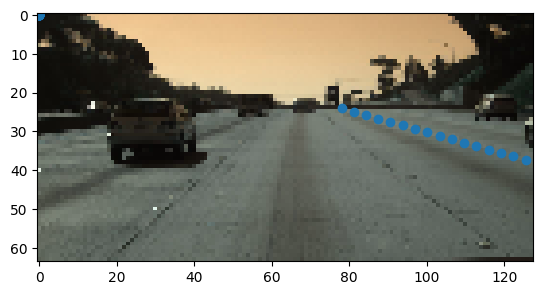

In [348]:
homography = HomographyDataset()

plt.imshow(homography[1][0].permute(1, 2, 0))
plt.scatter(x=homography[1][1][3][0], y=homography[1][1][3][1])

Now we need to implement the H-Net. It should return homography matrix that is parametrized by 6 numbers.
Corresponding section is CURVE FITTING USING H-NET in the[ LaneNet paper](https://arxiv.org/pdf/1802.05591.pdf).

We suggest to follow the paper and take 64x128 image as in input.

Homography projection contains discontinuities, therefore it could be quite difficult to train the network. In order to simplify the problem we propose not to train the homography from scratch, but train some correction to a good starting point.

The following code block contains the initial homography that you can use.


In [208]:
import torch

# important note: this homography matrix is suitable only for 64x128 resolution
R = torch.tensor(
            [[-2.0484e-01, -1.7122e+01,  3.7991e+02],
             [ 0.0000e+00, -1.6969e+01,  3.7068e+02],
             [ 0.0000e+00, -4.6739e-02,  1.0000e+00]],
            dtype=torch.float32, device=torch.device('cuda')
        )

Let's check the effect of this homography on the image.

In [11]:
!wget https://miro.medium.com/max/2560/1*b3HiwPg69Rw0L5iIMQMXOw.jpeg

--2024-01-07 18:02:24--  https://miro.medium.com/max/2560/1*b3HiwPg69Rw0L5iIMQMXOw.jpeg
Resolving miro.medium.com (miro.medium.com)... 162.159.152.4, 162.159.153.4, 2606:4700:7::a29f:9904, ...
Connecting to miro.medium.com (miro.medium.com)|162.159.152.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /v2/resize:fit:2560/1*b3HiwPg69Rw0L5iIMQMXOw.jpeg [following]
--2024-01-07 18:02:24--  https://miro.medium.com/v2/resize:fit:2560/1*b3HiwPg69Rw0L5iIMQMXOw.jpeg
Reusing existing connection to miro.medium.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 91108 (89K) [image/jpeg]
Saving to: '1*b3HiwPg69Rw0L5iIMQMXOw.jpeg.1'

1*b3HiwPg69Rw0L5iIM 100%[===================>]  88.97K  --.-KB/s    in 0.02s   

2024-01-07 18:02:24 (4.06 MB/s) - '1*b3HiwPg69Rw0L5iIMQMXOw.jpeg.1' saved [91108/91108]



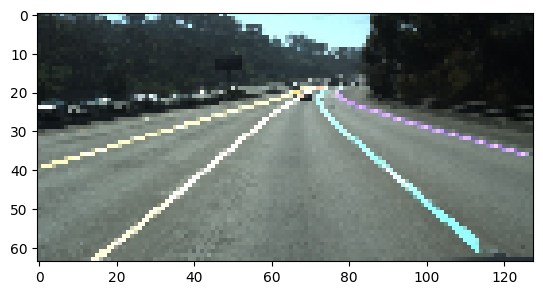

In [12]:
image = plt.imread('1*b3HiwPg69Rw0L5iIMQMXOw.jpeg')
image = cv2.resize(image, (128, 64))
plt.imshow(image)

As you can see it looks like a bird's eye view projection where lines are becoming parallel.

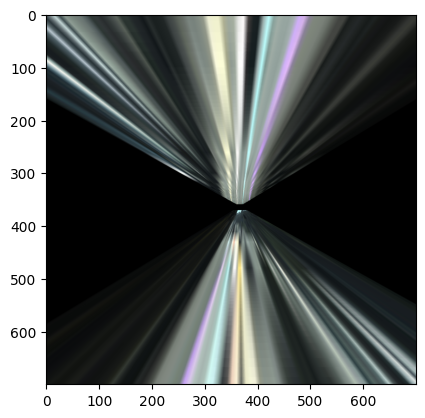

In [13]:
R_np = R.cpu().numpy()
plt.imshow(cv2.warpPerspective(image, R_np, dsize=(700, 700)))

As you can see it looks like a bird's eye view projection where lines are becoming parallel.

`This HNet architecture includes a series of convolutional layers followed by max pooling with the aim of learning hierarchical features from the input data. A fully connected layer performs the final classification based on the learned features: `

In [14]:
class HNet(nn.Module):
    def __init__(self):
        super(HNet, self).__init__()
        c = 16
        self.conv1 = nn.Conv2d(3, c, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(c)

        self.conv2 = nn.Conv2d(c, c, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(c)

        c *= 2
        self.conv3 = nn.Conv2d(c // 2, c, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(c)

        self.conv4 = nn.Conv2d(c, c, 3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(c)

        c *= 2
        self.conv5 = nn.Conv2d(c // 2, c, 3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(c)

        self.conv6 = nn.Conv2d(c, c, 3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(c)

        self.fc1 = nn.Linear(8192, 1024)
        self.bn7 = nn.BatchNorm1d(1024)
        
        self.fc2 = nn.Linear(1024, 6)       
    
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(2, stride=2)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(self.relu(self.bn2(self.conv2(x))))

        x = self.relu(self.bn3(self.conv3(x)))
        x = self.maxpool(self.relu(self.bn4(self.conv4(x))))

        x = self.relu(self.bn5(self.conv5(x)))
        x = self.maxpool(self.relu(self.bn6(self.conv6(x))))
        
        x = x.view(x.size(0), -1)
        x = self.relu(self.bn7(self.fc1(x)))
        x = self.fc2(x)        
        
        return x

Finally, we need to implement the loss to fit the network. This is the most difficult part of the project. Homography loss should do the following:

1. Project ground truth trajectory to the new plane according to the homography to obtain $(x', y')$.
2. Perform polynomial fitting $x' = f(y')$. Your code should work correctly with 2-nd and 3-rd order polynomials. Polynomial fitting should be done with the closed-form solution: $w = (Y^TY)^{-1}Y^Tx$ to be able to pass a gradient through.
3. Compute back projection with the inverse homography.
4. Compute loss between back projected $\hat{x}$ and ground truth $x$.

The full description can be found in the [LaneNet paper](https://arxiv.org/pdf/1802.05591.pdf).

**IMPORTANT NOTES**

* To fit the polynomial you need to compute the inverse matrix. Computation of the inverse is computation unstable operation. With the help of the SVD you can compute pseudo-inverse matrix: $(X^TX)^{-1}X^T$. In torch this function is called `torch.pinverse`.
* After projection use of the raw $y'$ can be impractical. The features for the polynomial fitting could have a high correlation and therefore solution can be unstable. At first, you need to map $y'$ to some fixed size segment and only then perform a fit.
* After projection some points can occur on the other side of image (bottom part of the projection in the example above). You may want to exclude them, because otherwise polynomial is not going to have much sense and gradients can have a dramatically large values. Positive $w$ in homogeneous coordinates indicates that point is on the wrong side.
* If use the homography provided above, your ground truth should have the same scale, as an image
* Every division in your network is a potential place to obtain `nan` in gradients. Use the following trick to obtain less divisions:
after computing the projection, remember the $w$. Then, before the back projection, multiply your vector by $w$. After back projection you will see that $w$ is equal to 1. So you don't need to devide your vector by $w$.
* You correction to the initial homography could be very big and can completely spoil the homography. So you may need to scale the output of the last layer in the HNet to obtain a smaller corrections.


`Let's make a custom HomographyLoss function, which designed for the task of homography transformation estimation, which takes the corrections and ground truth trace information, computes the homography matrix based on the corrections, and computes the loss by comparing the newly projected points with the ground points:`

In [83]:
class HomographyLoss(torch.nn.modules.loss._Loss):
    def __init__(self, reduction="mean", order=2, use_gpu=True, R=R):
        
        super().__init__(reduction=reduction)
        
        device = 'cuda' if use_gpu else 'cpu'
        self.device = torch.device(device)
        self.order = order
        self.R = R

    def forward(self, inputs, targets):
        losses = []
        for correction, gt_lanes in zip(inputs, targets):
            for lane in gt_lanes:
                if lane.sum() == 0:
                    continue
                lane_loss = self.compute_loss_for_lane(correction, lane)
                if lane_loss is not None:
                    losses.append(lane_loss)
        return torch.stack(losses).mean()

    def compute_loss_for_lane(self, correction, lane):
        H_correction_indices = [0, 1, 2, 4, 5, 7]
        H_correction = correction.flatten()
        H = self.R.flatten().clone()
        H[H_correction_indices] = H_correction.to(self.device)
        H = H.reshape((3, 3))

        points = lane.T
        index = points.nonzero().flatten().max().item() + 1
        points = points[:index, :]
        ones_col = torch.ones(points.shape[0], device=self.device)
        P = torch.column_stack((points, ones_col)).T.to(torch.float32)
        P_transformed = H @ P

        x_transformed = P_transformed[0, :].T
        y_transformed_squares = P_transformed[1, :] ** 2
        y_transformed = P_transformed[1, :]
        Y = torch.column_stack((y_transformed_squares, y_transformed, ones_col))
        w = torch.linalg.solve(Y.T @ Y, Y.T) @ x_transformed

        x_predicted = Y @ w
        P_predicted = torch.column_stack((x_predicted, y_transformed, ones_col)).T
        P_reprojected = torch.linalg.inv(H.detach()) @ P_predicted
        P_reprojected = torch.div(P_reprojected, P_reprojected[2, :])

        loss = ((points[:, 0].T - P_reprojected[0, :]) ** 2).mean()
        
        return loss
    

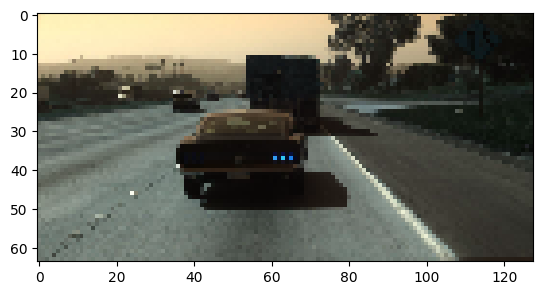

In [42]:
hnet = HNet()
batch = torch.stack((homography[0][0], homography[1][0]))
predicted_corrections = hnet(batch)
plt.imshow(homography[3][0].permute(1, 2, 0))

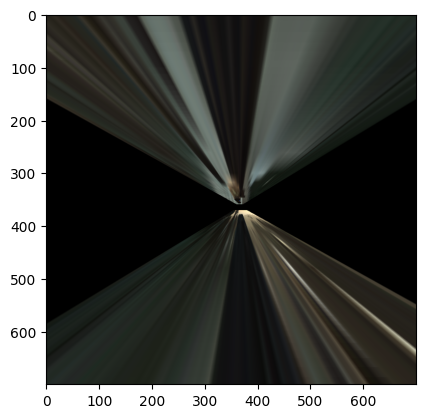

In [43]:
R_corrected_test_image_1 = torch.tensor(
    [
        [R[0, 0] + predicted_corrections[0][0], R[0, 1] + predicted_corrections[0][1], R[0, 2] + predicted_corrections[0][2]],
        [R[1, 0], R[1, 1] + predicted_corrections[0][3], R[1, 2] + predicted_corrections[0][4]],
        [R[2, 0], R[2, 1] + predicted_corrections[0][5], R[2, 2]],
    ]
)

plt.imshow(cv2.warpPerspective(homography[3][0].permute(1, 2, 0).numpy(), R_np, dsize=(700, 700)))

Finally, train the homography net with the 2-nd order polynomial fitting (you can 3-rd order but we found out that it is much easier to train h-net with the 2-nd order polynomials).

We found out that SGD fits much better for this architectures. Adam (and momentums inside) can ruin the weights because of the discontinuities in the target function surface.

Demonstrate the difference in homography loss between h-net and provided fixed homography on the validation samples.

`In article[1] H-Net is trained for a 3rd-order polynomial fit, with a scaled version of input image with dimension 128x64. The network is trained using Adam with a batch size of 10 and learning rate 5e-5 until convergence.`

In [194]:
BATCH_SIZE = 10
LR = 5e-5
NUM_EPOCHS = 20


hnet_train_dataset = HomographyDataset()
hnet_train_dataloader = torch.utils.data.DataLoader(hnet_train_dataset, batch_size=BATCH_SIZE, shuffle=False)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("gpu")


hnet_model = HNet().to(device)
optimizer = torch.optim.SGD(hnet_model.parameters(), lr=LR)
criterion = HomographyLoss()

for epoch in range(NUM_EPOCHS):
    
    hnet_model.train()
    epoch_losses = []
    
    for inputs, points in hnet_train_dataloader:
        inputs, points = inputs.to(device), points.to(device)
        coefs = hnet_model(inputs)
        loss = criterion(coefs, points)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.detach().cpu().numpy())
    
    epoch_loss = np.array(epoch_losses).mean()
    print(f"Epoch {epoch}, loss = {epoch_loss}")
    

Epoch 0, loss = 33609.90705206076
Epoch 1, loss = 5530.6791728250555
Epoch 2, loss = 5530.6791728250555
Epoch 3, loss = 5530.6791728250555
Epoch 4, loss = 5530.6791728250555
Epoch 5, loss = 5530.6791728250555
Epoch 6, loss = 5530.6791728250555
Epoch 7, loss = 5530.6791728250555
Epoch 8, loss = 5530.6791728250555
Epoch 9, loss = 5530.6791728250555
Epoch 10, loss = 5530.6791728250555
Epoch 11, loss = 5530.6791728250555
Epoch 12, loss = 5530.6791728250555
Epoch 13, loss = 5530.6791728250555
Epoch 14, loss = 5530.6791728250555
Epoch 15, loss = 5530.6791728250555
Epoch 16, loss = 5530.6791728250555
Epoch 17, loss = 5530.6791728250555
Epoch 18, loss = 5530.6791728250555
Epoch 19, loss = 5530.6791728250555


# Complete Pipeline

Now you need to implement a class that takes image and a set of $y$ coordinates as an input and returns the $x$ coordinate for each lane in this image.

It should contain the following steps:

1. Apply segmentation network to the image
2. Run DBSCAN over the embeddings for those pixels that are lanes.
3. Apply h-net to the image
4. Project pixel coordinates with the predicted homograpgy
5. Fit the 3-rd order polynomial
6. Predict the lane position for each provided $y$ (you should project this first).
7. Compute back projection and return the positions of $x$ for each lane.

Note: if you weren't able to train the H-Net, you can use the fixed homography here.

In [209]:
IMAGE_SIZE = (512, 256)

class LaneDetector:

    def __init__(self, enet, hnet= None, use_gpu=True, R=R, image_size = IMAGE_SIZE, with_projection=False):
        self.image_size = image_size
        device = 'cuda' if use_gpu else 'cpu'
        self.enet = enet
        self.hnet = hnet
        self.default_homography = R
        self.device = torch.device(device)
        self.eps = 1.0
        self.with_projection = with_projection
  
    def __call__(self, image, y_positions=None):
        image = self._preprocess_image(image)
        if y_positions is None:
            y_positions = np.linspace(50, image.shape[2], 30)
        
        binary_logits, instance_embeddings = self.enet(image)
        segmentation_map = binary_logits.squeeze().argmax(dim=0)
        instances_map = self._cluster(segmentation_map, instance_embeddings)
                
        lanes = self._extract_lanes(instances_map)
        print(f"Detected {len(lanes)} lanes")
        
        if self.with_projection:
            projected_lanes = self._project_lanes(lanes)
            coefs = self._fit(projected_lanes)
            y_positions_projected = self._project_y(y_positions)
            fitted_lanes = self._predict_lanes(coefs, y_positions_projected)
            reprojected_lanes = self._reproject(fitted_lanes)
            predicted_lanes = reprojected_lanes
        else:
            coefs = self._fit(lanes)
            fitted_lanes = self._predict_lanes(coefs, y_positions)
            predicted_lanes = fitted_lanes
        
        predicted_lanes = self._postprocess_result(predicted_lanes)
        return instances_map.cpu().numpy(), predicted_lanes.cpu().numpy()
    
    def _cluster(self, segmentation_map, instance_embeddings):
        segmentation_map = segmentation_map.flatten()
        instance_embeddings = instance_embeddings.squeeze().permute(1, 2, 0).reshape(segmentation_map.shape[0], -1)
        assert segmentation_map.shape[0] == instance_embeddings.shape[0]
        
        mask_indices = segmentation_map.nonzero().flatten()
        cluster_data = instance_embeddings[mask_indices].detach().cpu()
        
        clusterer = DBSCAN(eps=self.eps)
        labels = clusterer.fit_predict(cluster_data)
        labels = torch.tensor(labels, dtype=instance_embeddings.dtype, device=self.device)
        
        instances_map = torch.zeros(instance_embeddings.shape[0], dtype=instance_embeddings.dtype, device=self.device)
        instances_map[mask_indices] = labels
        instances_map = instances_map.reshape(self.image_size[::-1])
        
        return instances_map
    
    def _extract_lanes(self, instances_map, scale=False):
        lanes = []
        lane_indices = instances_map.unique()[1:]
    
        for index in lane_indices:
            coords = (instances_map == index).nonzero(as_tuple=True)
            if scale:
                coords = [c / 4 for c in coords]
            coords = coords[::-1]  # from (y, x) to (x, y)
            coords = torch.stack(coords).to(instances_map.dtype)
            lanes.append(coords)
    
        return lanes

    def _fit(self, lanes):
        coefs = []

        for lane in lanes:
            x = lane[0, :].unsqueeze(dim=1)
            y = lane[1, :]
            Y = torch.stack((y, torch.ones(y.shape[0], device=self.device))).T
            w = torch.linalg.inv(Y.T @ Y) @ Y.T @ x
            coefs.append(w)

        return coefs

    def _postprocess_result(self, lanes):
        processed = []

        for i, lane in enumerate(lanes):
            lane = lane.T
            lane[:, 2] = i
            ind1 = lane[:, 0] >= 0
            ind2 = lane[:, 0] <= 512
            index = torch.logical_and(ind1, ind2)
            lane = lane[index, :]
            processed.append(lane)

        return torch.cat(processed, dim=0)

    def _predict_lanes(self, coefs, y_positions):
        lanes = []

        for coef in coefs:
            c, d = coef
            lane = []
            for y in y_positions:
                x = c * y + d
                lane.append((x, y, 1))
            lanes.append(torch.tensor(lane, device=self.device).T)

        return lanes
    
    def _preprocess_image(self, image):
        image = cv2.resize(image, self.image_size, interpolation=cv2.INTER_LINEAR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image[..., None]
        image = torch.from_numpy(image).float().permute((2, 0, 1)).unsqueeze(dim=0).to(self.device)
        
        return image

    def _project_lanes(self, lanes):
        projected = []

        for lane in lanes:
            ones = torch.ones((1, lane.shape[1]), device=self.device)
            P = torch.cat((lane, ones), dim=0)
            P_projected = self._default_homography @ P
            P_projected = P_projected / P_projected[2, :]
            projected.append(P_projected)

        return projected

    def _project_y(self, y_positions):
        y_positions = torch.from_numpy(y_positions).to(torch.float32).to(self.device)
        Y = torch.stack((
            torch.zeros(y_positions.shape[0], device=self.device),
            y_positions,
            torch.ones(y_positions.shape[0], device=self.device)
        ))
        Y_projected = self._default_homography @ Y
        Y_projected = Y_projected / Y_projected[2, :]
        y_positions_projected = Y_projected[1, :]

        return y_positions_projected

    def _reproject(self, lanes):
        reprojected = []

        for lane in lanes:
            lane_reprojected = torch.linalg.inv(self._default_homography) @ lane
            lane_reprojected = lane_reprojected / lane_reprojected[2, ]
            reprojected.append(lane_reprojected)

        return reprojected

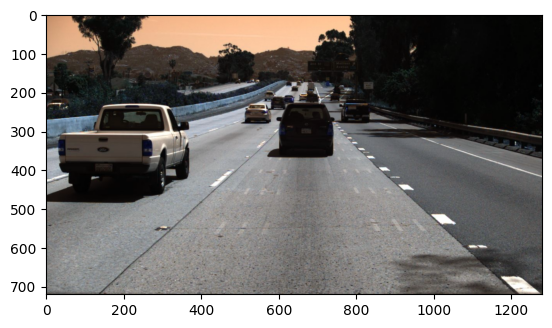

In [328]:
test_image = cv2.imread("/kaggle/input/tusimple/TUSimple/test_set/clips/0530/1492626047222176976_0/1.jpg")
plt.imshow(test_img)

In [332]:
detector = LaneDetector(enet=model)
res = detector(test_image)

Detected 2 lanes


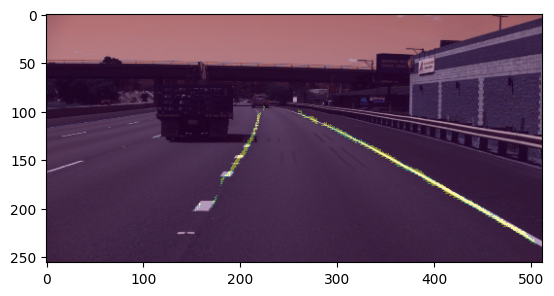

In [330]:
plt.imshow(cv2.resize(test_image, (512, 256)))
plt.imshow(res[0], alpha=0.4)

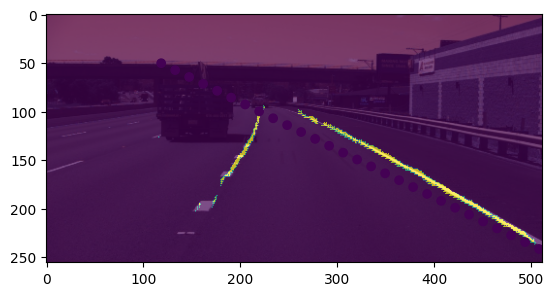

In [331]:
plt.imshow(cv2.resize(test_image, (512, 256)))
plt.imshow(res[0], alpha=0.7)
plt.scatter(x=res[1][:,0], y=res[1][:, 1], c=res[1][:, 2])

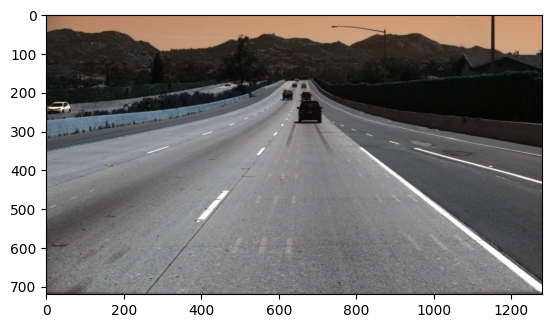

In [214]:
test_image_2 = cv2.imread("/kaggle/input/tusimple/TUSimple/test_set/clips/0530/1492626236105069364_0/12.jpg")
plt.imshow(test_image_2)

In [333]:
detector = LaneDetector(enet=model)
res = detector(test_image_2)

Detected 2 lanes


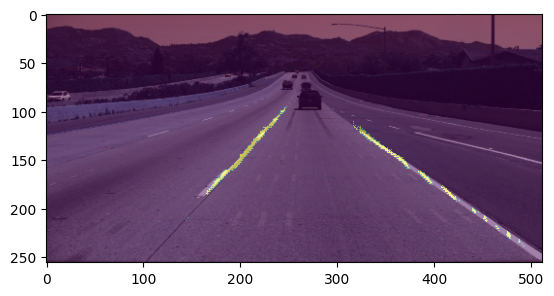

In [216]:
plt.imshow(cv2.resize(test_image_2, (512, 256)))
plt.imshow(res[0], alpha=0.5)

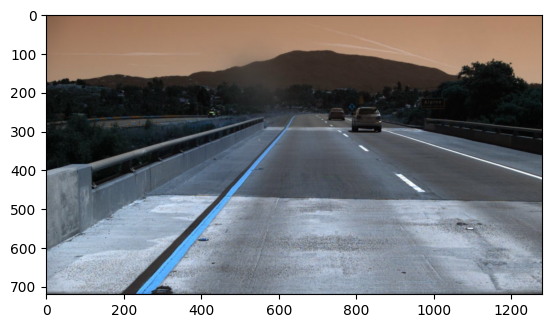

In [267]:
test_image_3 = cv2.imread("/kaggle/input/tusimple/TUSimple/test_set/clips/0531/1492626674406553912/20.jpg")
plt.imshow(test_image_3)

In [268]:
detector = LaneDetector(enet=model)
res = detector(test_image_3)

Detected 1 lanes


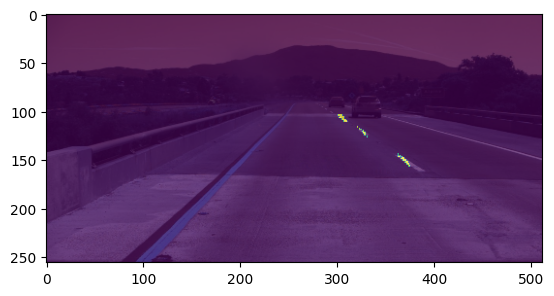

In [269]:
plt.imshow(cv2.resize(test_image_3, (512, 256)))
plt.imshow(res[0], alpha=0.7)

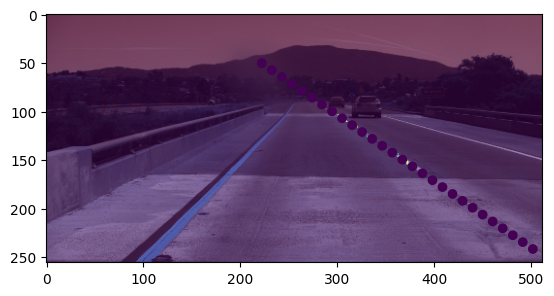

In [271]:
plt.imshow(cv2.resize(test_image_3, (512, 256)))
plt.imshow(res[0], alpha=0.5)
plt.scatter(x=res[1][:,0], y=res[1][:, 1], c=res[1][:, 2])

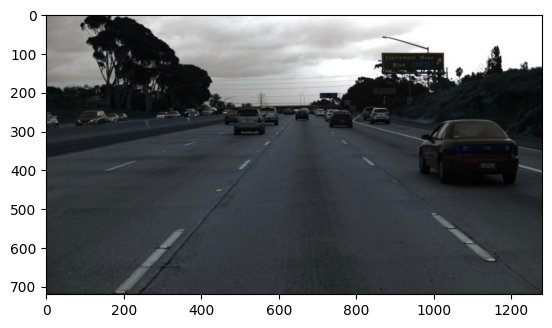

In [222]:
test_image_4 = cv2.imread("/kaggle/input/tusimple/TUSimple/test_set/clips/0601/1494452381594376146")
plt.imshow(test_image_3)

In [223]:
detector = LaneDetector(enet=model)
res = detector(test_image_4)

Detected 2 lanes


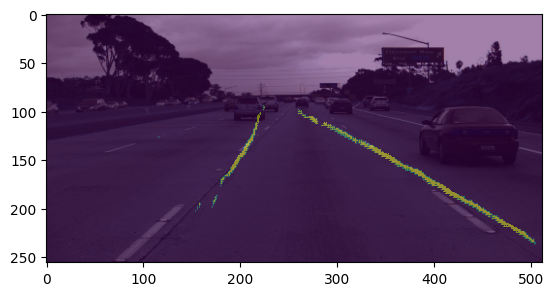

In [334]:
plt.imshow(cv2.resize(test_image_4, (512, 256)))
plt.imshow(res[0], alpha=0.5)

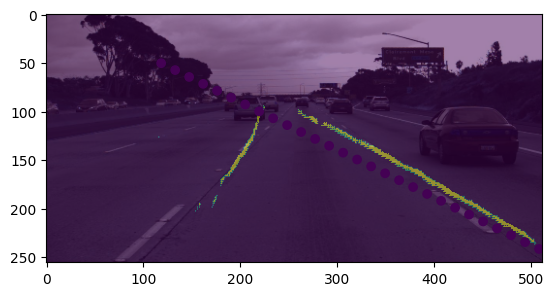

In [335]:
plt.imshow(cv2.resize(test_image_4, (512, 256)))
plt.imshow(res[0], alpha=0.5)
plt.scatter(x=res[1][:,0], y=res[1][:, 1], c=res[1][:, 2])

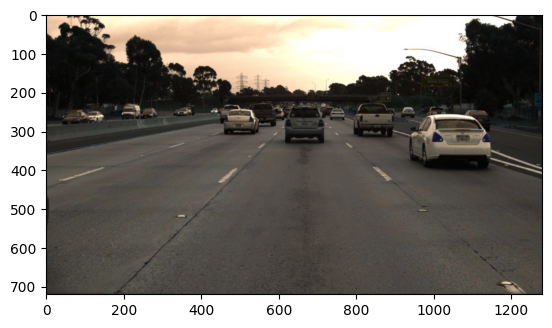

In [235]:
test_image_5 = cv2.imread("/kaggle/input/tusimple/TUSimple/test_set/clips/0601/1494452467556714982/13.jpg")
plt.imshow(test_image_5)

In [236]:
detector = LaneDetector(enet=model)
res = detector(test_image_5)

Detected 2 lanes


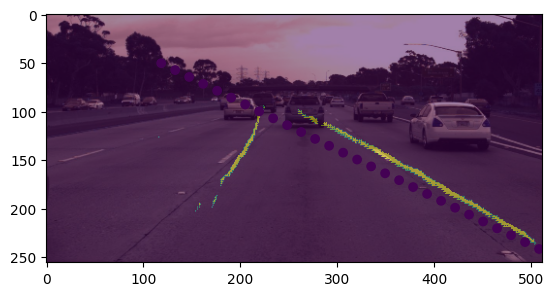

In [338]:
plt.imshow(cv2.resize(test_image_5, (512, 256)))
plt.imshow(res[0], alpha=0.5)
plt.scatter(x=res[1][:,0], y=res[1][:, 1], c=res[1][:, 2])

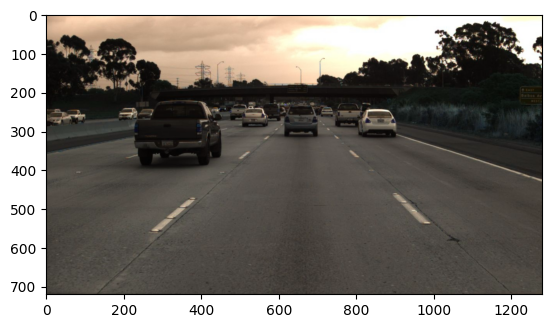

In [256]:
test_image_6 = cv2.imread("/kaggle/input/tusimple/TUSimple/test_set/clips/0601/1494452477551592645/2.jpg")
plt.imshow(test_image_6)

In [257]:
detector = LaneDetector(enet=model)
res = detector(test_image_6)

Detected 2 lanes


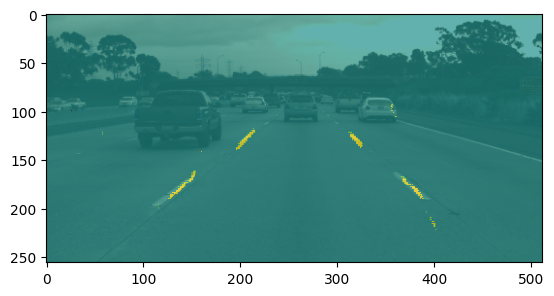

In [260]:
plt.imshow(cv2.resize(test_image_6, (512, 256)))
plt.imshow(res[0], alpha=0.7)

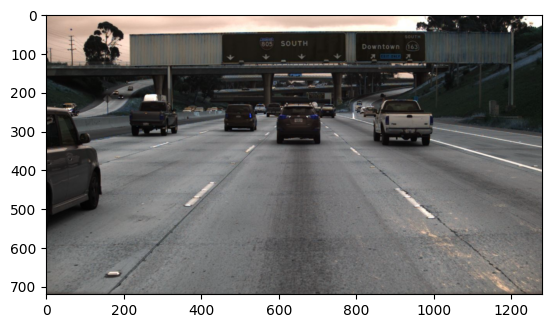

In [324]:
test_image_7 = cv2.imread("/kaggle/input/tusimple/TUSimple/test_set/clips/0601/1494452537526888921/17.jpg")
plt.imshow(test_image_7)

In [340]:
detector = LaneDetector(enet=model)
res = detector(test_image_7)

Detected 2 lanes


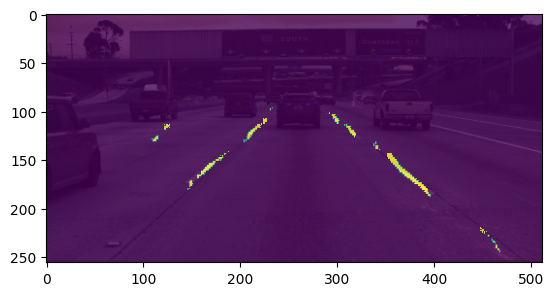

In [326]:
plt.imshow(cv2.resize(test_image_7, (512, 256)))
plt.imshow(res[0], alpha=0.8)

 ` LaneDetector represents a robust lane detection pipeline that includes image preprocessing, neural network inference, clustering, polynomial fitting, and projection for accurate lane localization`

<h4> In this work I used next literature sources: </h4>
    
1. Towards End-to-End Lane Detection: an Instance Segmentation Approach. Article No. 286 - 291. Publisher. IEEE. https://doi.org/10.48550/arXiv.1802.05591

2.  ENet: A deep neural network architecture for real-time semantic segmentation. arXiv [Preprint]. arXiv:1606.02147. Google Scholar. Poudel, R. P., Liwicki

3. Semantic instance segmentation with a discriminative loss function. B. Brabandere, D Neven, L Van Gool. arXiv preprint arXiv:1708.02551, 2017.
    
4. Implementing Lane Detection in CARLA using LaneNet. https://medium.com/@diazoangga/implementing-lane-detection-in-carla-using-lanenet-330d8fd8720c
    
5. Lane detection project: https://www.kaggle.com/code/pavelsyomin/lane-detection-pavel-syomin